In [70]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import sys
sys.path.append('/Users/gsinyakov/ts_course_summer/')

In [72]:
import pandas as pd
from load_dataset import Dataset
from model import TimeSeriesPredictor
from sklearn.linear_model import LinearRegression

In [73]:
import plotting

## Разбор

#### Возьмем часовой временной ряд

In [74]:
dataset = Dataset('../data/Dataset')

In [75]:
ts = dataset['hour_2263.csv']

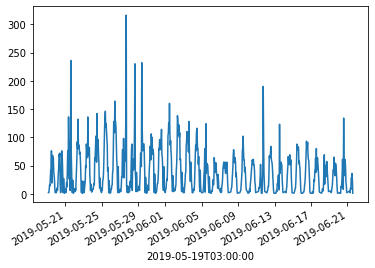

In [76]:
ts.plot()

#### Разделим на трейн и тест

In [77]:
ts_train, ts_test = ts[:-100], ts[-100:]

#### Создадим инстанс предиктора с линейной регрессией в качестве базы

In [78]:
predictor = TimeSeriesPredictor(
    granularity='PT1H',
    num_lags=14,
    Model=LinearRegression,
    sigma=3
)

#### Обучим модель на трейне

In [79]:
predictor.fit(ts_train)

#### Используя обученную модель, соберем статистику с трейна

In [80]:
predictor.fit_statistics(ts_train)

In [81]:
predictor.std

27.306385954508798

#### Используя найденную статистику (стандартное отклонение от остатков), получим доверительные интервалы

In [82]:
predictor.get_prediction_intervals(ts_test)

(2019-05-19T03:00:00
 2019-06-16 06:00:00   -74.919158
 2019-06-16 07:00:00   -66.919158
 2019-06-16 08:00:00   -61.919158
 2019-06-16 09:00:00   -49.919158
 2019-06-16 10:00:00   -31.919158
                          ...    
 2019-06-21 10:00:00   -53.919158
 2019-06-21 11:00:00   -54.919158
 2019-06-21 12:00:00   -45.919158
 2019-06-21 13:00:00   -56.919158
 2019-06-21 14:00:00   -80.919158
 Name: 1.0, Length: 100, dtype: float64,
 2019-05-19T03:00:00
 2019-06-16 06:00:00     88.919158
 2019-06-16 07:00:00     96.919158
 2019-06-16 08:00:00    101.919158
 2019-06-16 09:00:00    113.919158
 2019-06-16 10:00:00    131.919158
                           ...    
 2019-06-21 10:00:00    109.919158
 2019-06-21 11:00:00    108.919158
 2019-06-21 12:00:00    117.919158
 2019-06-21 13:00:00    106.919158
 2019-06-21 14:00:00     82.919158
 Name: 1.0, Length: 100, dtype: float64)

#### Получим one step ahead предсказания на тесте

In [83]:
predictions = predictor.predict_batch(ts_train, ts_test)

In [84]:
predictions

2019-05-19T03:00:00
2019-06-16 06:00:00    10.457296
2019-06-16 07:00:00    19.154960
2019-06-16 08:00:00    26.526698
2019-06-16 09:00:00    32.941612
2019-06-16 10:00:00    42.541620
                         ...    
2019-06-21 10:00:00    18.790441
2019-06-21 11:00:00    31.956985
2019-06-21 12:00:00    35.190963
2019-06-21 13:00:00    44.868706
2019-06-21 14:00:00    44.782905
Length: 100, dtype: float64

#### Получим аномалии

In [85]:
anoms = predictor.detect(ts_test, predictions)

In [86]:
anoms

2019-05-19T03:00:00
2019-06-20 14:00:00    134.0
Name: 1.0, dtype: float64

In [87]:
plotting.plot_multiple_ts(ts, ts_test, predictions, anoms)

## Практика

In [69]:
from typing import Dict, Callable
import pandas as pd
import numpy as np
import isodate
from copy import deepcopy

from monthdelta import monthdelta


def get_timedelta_from_granularity(granularity: str):
    datetime_interval = isodate.parse_duration(granularity)
    if isinstance(datetime_interval, isodate.duration.Duration):
        years, months = datetime_interval.years, datetime_interval.months
        total_months = int(years * 12 + months)
        datetime_interval = monthdelta(months=total_months)
    return datetime_interval


class TimeSeriesPredictor:
    def __init__(
            self,
            granularity: str,
            num_lags: int,
            Model,
            mappers: Dict[str, Callable] = {},
            sigma: float = 2.3,
            *args, **kwargs
    ):

        self.granularity = granularity
        self.num_lags = num_lags
        self.model = Model(*args, **kwargs)
        self.mappers = mappers
        self.fitted = False
        self.sigma = sigma
        self.std = None

    def transform_into_matrix(self, ts: pd.Series) -> pd.DataFrame:
        """
        Transforms time series into lags matrix to allow
        applying supervised learning algorithms

        Parameters
        ------------
        ts
            Time series to transform

        Returns
        --------
        lags_matrix
            Dataframe with transformed values
        """

        ts_values = ts.values
        data = {}
        for i in range(self.num_lags + 1):
            data[f'lag_{self.num_lags - i}'] = np.roll(ts_values, -i)

        lags_matrix = pd.DataFrame(data)[:-self.num_lags]
        lags_matrix.index = ts.index[self.num_lags:]

        return lags_matrix

    def enrich(
            self,
            lags_matrix: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Adds external features to time series

        Parameters
        ------------
        lags_matrix
            Pandas dataframe with transformed time-series values
        mappers
            Dictionary of functions to map each timestamp of lags matrix.
            Each function should take timestamp as the only positional parameter
            and return value of your additional feature for that timestamp
        """

        mappers = self.mappers
        for name, mapper in mappers.items():
            feature = pd.Series(lags_matrix.index.map(mapper), lags_matrix.index, name=name)
            lags_matrix[name] = feature

        return lags_matrix

    def fit(self, ts: pd.Series, *args, **kwargs):
        lag_matrix = self.transform_into_matrix(ts)
        feature_matrix = self.enrich(lag_matrix)

        X, y = feature_matrix.drop('lag_0', axis=1), feature_matrix['lag_0']
        self.model.fit(X, y, *args, **kwargs)
        self.fitted = True

    def predict_next(self, ts_lags, n_steps=1):
        if not self.model:
            raise ValueError('Model is not fitted yet')

        predict = {}

        ts = deepcopy(ts_lags)
        for _ in range(n_steps):
            next_row = self.generate_next_row(ts)
            next_timestamp = next_row.index[-1]
            value = self.model.predict(next_row)[0]
            predict[next_timestamp] = value
            ts[next_timestamp] = value
        return pd.Series(predict)

    def predict_batch(self, ts: pd.Series, ts_batch: pd.Series = pd.Series()):
        """
        Makes one step ahead predictions for each point in ts_batch.
        
        Parameters
        ----------
        ts
            History batch, must be at least self.num_lags length
        ts_batch
            New data to predict
            
        Returns
        --------
        ts_pred
            Batch of len(ts_batch) with predicted values
        """
        if not self.model:
            raise ValueError('Model is not fitted yet')

        unite_ts = ts.append(ts_batch)
        matrix = self.enrich(self.transform_into_matrix(unite_ts))

        data_batch = matrix[-len(ts_batch):]
        preds = self.model.predict(data_batch.drop('lag_0', axis=1))
        
        ts_pred = pd.Series(index=data_batch.index, data=preds)

        return ts_pred

    def generate_next_row(self, ts):
        """
        Takes time-series as an input and returns next row, that is fed to the fitted model,
        when predicting next value.

        Parameters
        ----------
        ts : pd.Series(values, timestamps)
            Time-series to detect on

        Returns
        ---------
        feature_matrix : pd.DataFrame
            Pandas dataframe, which contains feature lags of
            shape(1, num_lags+len(external_feautres))
        """

        delta = get_timedelta_from_granularity(self.granularity)
        next_timestamp = pd.to_datetime(ts.index[-1]) + delta
        lag_dict = {'lag_{}'.format(i): [ts[-i]] for i in range(1, self.num_lags + 1)}
        df = pd.DataFrame.from_dict(lag_dict)
        df.index = [next_timestamp]
        df = self.enrich(df)

        return df

    def fit_statistics(self, ts):
        preds = self.predict_batch(ts)
        # ваш код здесь

    def get_prediction_intervals(self, y_pred):
        # ваш код здесь
        return lower, upper

    def detect(self, ts_true, ts_pred):
        # ваш код здесь        
        pass

    def set_params(self, **parameters):
        """
        Sets params
        """
        self_params = {'num_lags'}
        for parameter, value in parameters.items():
            if parameter in self_params:
                setattr(self,  parameter, value)
            else:
                setattr(self.model, parameter, value)
        pass

    def get_params(self):
        """
        Gets params
        """
        params = {
            'num_lags': self.num_lags
        }
        params.update(self.model.get_params())
        return params


/Users/gsinyakov/ts_course_summer/.env/lib/python3.7/site-packages/ipykernel_launcher.py:111: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



### Задание

1. Добавить в класс TimeSeriesPredictor метод fit_statistics, который при помощи обученной модели получает остатки
   предсказаний на трейне и возвращает стандартное отклонение остатков.
   def fit_statistics(self, ts_train):
       # получаю предсказания ts_train
       # получаю остатки
       # записываю стандартное отклонение в аттрибут std - self.std = std

2. Добавить в класс TimeSeriesPredictor метод get_prediction_intervals, который принимает предсказанный батч ts_pred,    и, используя std на трейне возвращает для каждой точки ее lower и upper доверительные интервалы.

3. Добавить в класс TimeSeriesPredictor метод detect, который принимает на вход ts_true и ts_pred и возвращает          значения ряда, выходящие за границы доверительных интервалов. 

### Задание*

1. Добавить метод fit_seasonal_statistics, который бы возвращал стандартное отклонение остатков предсказания для          K равных участков внутри периода сезонности. Например для часовых рядов возвращал сигмы для K=3 участков: с        0 до 8-ми утра, с 8-ми утра до 16 вечера, с 16 до полуночи. 
   def fit_seasonal_statistics(self, ts_train, n_splits=3, period=24):
       # получаю предсказания ts_train
       # разбиваю остатки на datetime интервалы длинной period/n_splits
       # считаю стандартное отклонение для каждого участка
       # записываю стандартное отклонение в аттрибут self.season_std = {
                                                                        datetime_range_1: std_1,
                                                                        datetime_range_2: std_2,
                                                                        datetime_range_3: std_3,
                                                                        }
2. В метод get_prediction_intervals добавить параметр season=True/False, который, будучи включенным, определяет к 
   какому из интервалов в self.season_std относится каждая точка из ts_pred, и, использую соответствующий std, 
   возвращает для нее доверительные интервалы.